In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

### K-mean standard

In [2]:
class KMeans:
    """
    Implements the K-means clustering algorithm from scratch using NumPy.
    Parameters:
    ----------
    K (int): The number of clusters (default=3)
    max_iter (int): The maximum number of iterations to run (default=100)
    tol (float): Tolerance for convergence. The algorithm stops if the centroids 
                 move less than this distance (default=10e-4) 
    """
    def __init__(self, K=3, max_iter=100, tol=1e-4, n_init=10, random_state=None):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init

        if random_state:
            np.random.seed(random_state)

        self.centroids = None # Stores the final centroids
        self.labels_ = None   # Stores the final labels for each data point
        self.inertia_ = None   # Stores best WCSS

    def _init_centroids(self, X):
        """
        Initializes the centroids by randomly selecting K points from the
        dataset X.

        Note: This is the simple "random" method. K-means++ is a 
        superior initialization strategy.
        """
        n_samples, _ = X.shape
        rand_indices = np.random.choice(n_samples, self.K, replace=False)
        centroids = X[rand_indices]
        return centroids
    
    def _assign_labels(self, X, centroids):
        """
        Assigns each point in X to the closest centroid.
        This is the "Assignment Step" (E-Step).
        """
        labels = []

        for point in X:
            distances_to_centroids = np.sum((centroids - point)**2, axis=1)

            closest_centroid_index = np.argmin(distances_to_centroids)
            labels.append(closest_centroid_index)

        return np.array(labels)
    
    def _update_centroids(self, X, labels):
        """
        Updates the centroids to be the mean of all points assigned to them.
        This is the "Update Step" (M-Step).
        """
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            # Get all data points assigned to cluster k
            cluster_points = X[labels == k]

            # Handle the important edge case of an empty cluster
            if len(cluster_points) > 0:
                # Calculate the mean of the points to get the new centroid
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[k] = X[np.random.choice(X.shape[0])]
        return new_centroids
    
    def _has_converged(self, old_centroids, new_centroids):
        """
        Checks if the centroids have stopped moving (within tolerance).
        """
        # Using np.allclose is a robust way to check if two arrays are
        # element-wise equal within a tolerance.
        return np.allclose(old_centroids, new_centroids, atol=self.tol)
    
    def _calculate_inertia(self, X, labels, centroids):
        total_inertia = 0
        for k in range(self.K):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia_k = np.sum((cluster_points - centroids[k]) ** 2)
                total_inertia += inertia_k
        return total_inertia

    def fit(self, X):
        """
        Trains the K-means model on the dataset X.
        """

        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        for i in range(self.n_init):
            current_centroids = self._init_centroids(X)
            current_labels = None

            for _ in range(self.max_iter):
                # Store old centroids to check for convergence
                old_centroids = current_centroids.copy()

                # Step 1: Assign labels (E-Step)
                current_labels = self._assign_labels(X, current_centroids)

                # Step 2: Update centroids (M-Step)
                current_centroids = self._update_centroids(X, current_labels)

                # Step 3: Check for convergence
                if self._has_converged(old_centroids, current_centroids):
                    break
                
            current_inertia = self._calculate_inertia(X, current_labels, current_centroids)
            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centroids = current_centroids.copy()
                best_labels = current_labels.copy()
        
        self.centroids = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia

    def predict(self, X_new):
        """
        Predicts the cluster for new data points X_new using the
        already trained centroids.
        """
        if self.centroids is None:
            raise RuntimeError("Model has not been fitted yet. Call .fit() first.")
        # This is just the assignment step
        return self._assign_labels(X_new, self.centroids)

### Test

#### Create data

In [3]:
X, y_true = make_blobs(n_samples=300, 
                       centers=4, 
                       cluster_std=0.80, 
                       random_state=42)

#### Initialize and train the model

In [4]:
kmeans = KMeans(K=4, max_iter=100, n_init=10, random_state=42)
kmeans.fit(X)

#### Get the results

In [5]:
labels = kmeans.labels_
centroids = kmeans.centroids
inertia = kmeans.inertia_

#### Plot the results

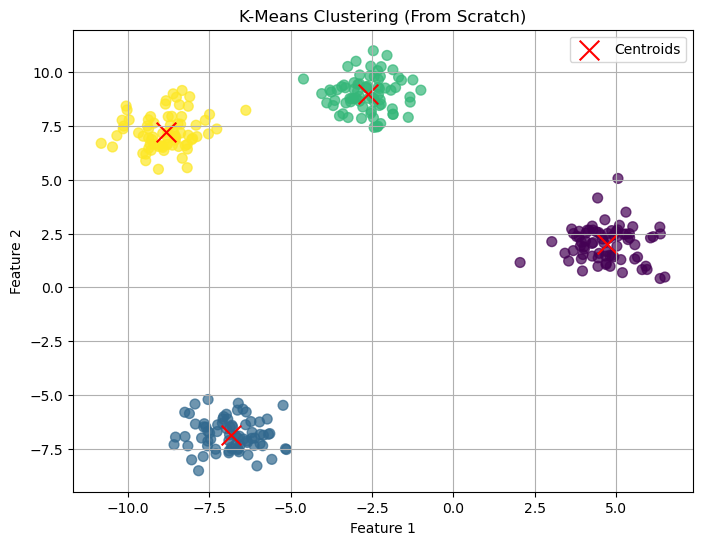

In [6]:
plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=50, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker="x", s=200, label="Centroids")

plt.title('K-Means Clustering (From Scratch)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()